# IMDB Movie Rating Prediction

## EDA & Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection._split import _BaseKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tqdm import tqdm

import shap
shap.initjs()

In [3]:
import kagglehub
import os

# Download the dataset and get the path to the directory
path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

# List all files in the directory to find the CSV file
files = os.listdir(path)
print("Files in dataset:", files)

csv_file = next((f for f in files if "movies" in f and f.endswith(".csv")), None)

if csv_file:
    full_path = os.path.join(path, csv_file)
    df = pd.read_csv(full_path)
    print("Data preview:")
    print(df.head())
else:
    print("CSV file not found in the downloaded dataset.")


Files in dataset: ['TMDB_all_movies.csv']
Data preview:
   id                             title  vote_average  vote_count    status  \
0   2                             Ariel           7.1       335.0  Released   
1   3               Shadows in Paradise           7.3       369.0  Released   
2   5                        Four Rooms           5.8      2628.0  Released   
3   6                    Judgment Night           6.5       331.0  Released   
4   8  Life in Loops (A Megacities RMX)           7.5        27.0  Released   

  release_date     revenue  runtime      budget    imdb_id  ...  \
0   1988-10-21         0.0     73.0         0.0  tt0094675  ...   
1   1986-10-17         0.0     74.0         0.0  tt0092149  ...   
2   1995-12-09   4257354.0     98.0   4000000.0  tt0113101  ...   
3   1993-10-15  12136938.0    109.0  21000000.0  tt0107286  ...   
4   2006-01-01         0.0     80.0     42000.0  tt0825671  ...   

                         spoken_languages  \
0                    

In [4]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (1025037, 28)


In [5]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025037 entries, 0 to 1025036
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1025037 non-null  int64  
 1   title                    1025025 non-null  object 
 2   vote_average             1025035 non-null  float64
 3   vote_count               1025035 non-null  float64
 4   status                   1025035 non-null  object 
 5   release_date             911011 non-null   object 
 6   revenue                  1025035 non-null  float64
 7   runtime                  1025035 non-null  float64
 8   budget                   1025035 non-null  float64
 9   imdb_id                  593467 non-null   object 
 10  original_language        1025035 non-null  object 
 11  original_title           1025025 non-null  object 
 12  overview                 843842 non-null   object 
 13  popularity               102

### There are several columns that are not meaningful for our analysis:

1. **id** and **imdb_id** contain only identifiers
2. **overview** has summary of the movie's plot which is long text data
3. **poster_path** has link to movie's poster



In [6]:
df = df.drop(columns=['id', 'imdb_id', 'overview', 'poster_path'])

In [7]:
print(f'Shape of the dataset after dropping: {df.shape}')

Shape of the dataset after dropping: (1025037, 24)


In [8]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                          12
vote_average                    2
vote_count                      2
status                          2
release_date               114026
revenue                         2
runtime                         2
budget                          2
original_language               2
original_title                 12
popularity                      2
tagline                    872565
genres                     296999
production_companies       551398
production_countries       405014
spoken_languages           393232
cast                       340571
director                   184665
director_of_photography    778494
writers                    528019
producers                  698353
music_composer             924766
imdb_rating                593768
imdb_votes                 593768
dtype: int64


### We will drop the rows with missing **imdb_rating**, which is our target for this project

In [9]:
rows_before = df.shape[0]
df = df.dropna(subset=['imdb_rating'])
rows_after = df.shape[0]
print(f'Shape of the data after removing NA: {df.shape}')
print(f'Number of rows dropped: {rows_before - rows_after}')

Shape of the data after removing NA: (431269, 24)
Number of rows dropped: 593768


In [10]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                           0
vote_average                    0
vote_count                      0
status                          0
release_date                 8271
revenue                         0
runtime                         0
budget                          0
original_language               0
original_title                  0
popularity                      0
tagline                    338092
genres                      54261
production_companies       155344
production_countries        96058
spoken_languages            93625
cast                        63493
director                    27094
director_of_photography    268826
writers                    130650
producers                  227786
music_composer             347031
imdb_rating                     0
imdb_votes                      0
dtype: int64


### We will also remove the rows with missing release_date since it only contains a small portion of data.

In [11]:
df = df.dropna(subset=['release_date'])
print(f'Shape of the data after removing NA: {df.shape}')

Shape of the data after removing NA: (422998, 24)


In [12]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 422998 entries, 0 to 1024934
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   title                    422998 non-null  object 
 1   vote_average             422998 non-null  float64
 2   vote_count               422998 non-null  float64
 3   status                   422998 non-null  object 
 4   release_date             422998 non-null  object 
 5   revenue                  422998 non-null  float64
 6   runtime                  422998 non-null  float64
 7   budget                   422998 non-null  float64
 8   original_language        422998 non-null  object 
 9   original_title           422998 non-null  object 
 10  popularity               422998 non-null  float64
 11  tagline                  91920 non-null   object 
 12  genres                   374598 non-null  object 
 13  production_companies     275135 non-null  object 

### Target column

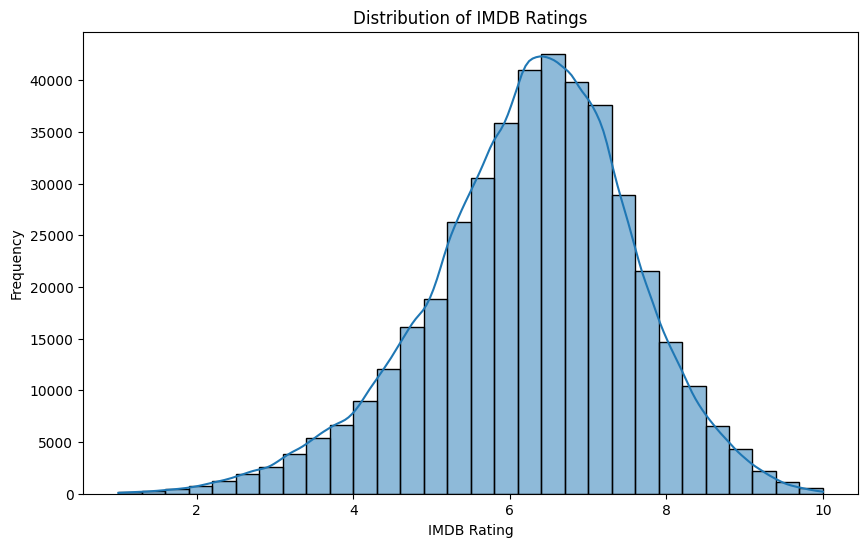

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['imdb_rating'], bins=30, kde=True)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

## Input variables
### vote_count & vote_average

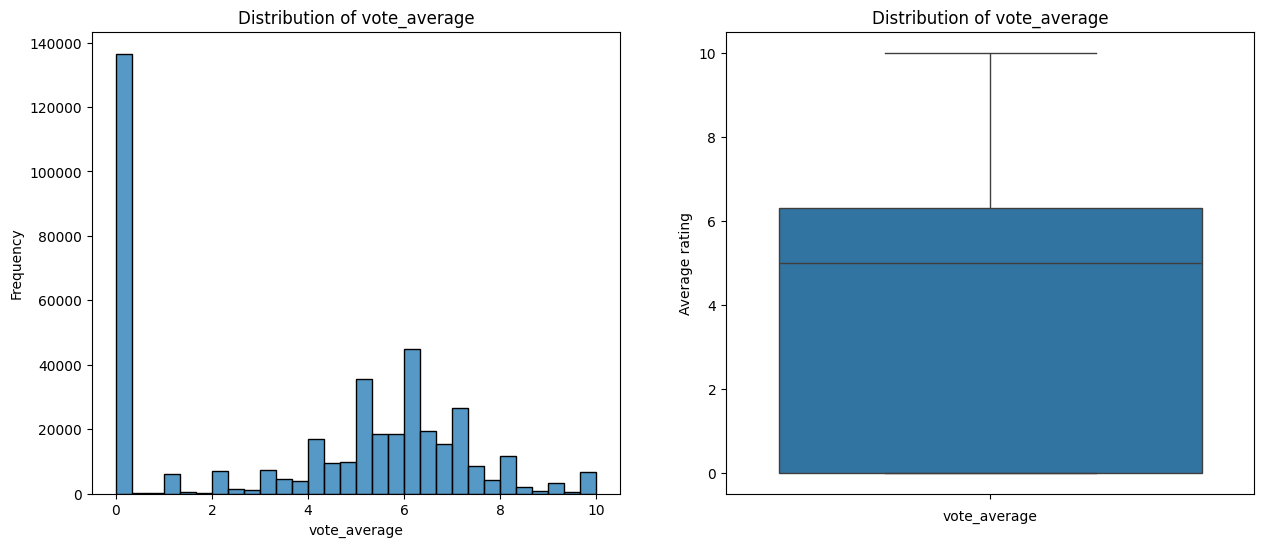

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

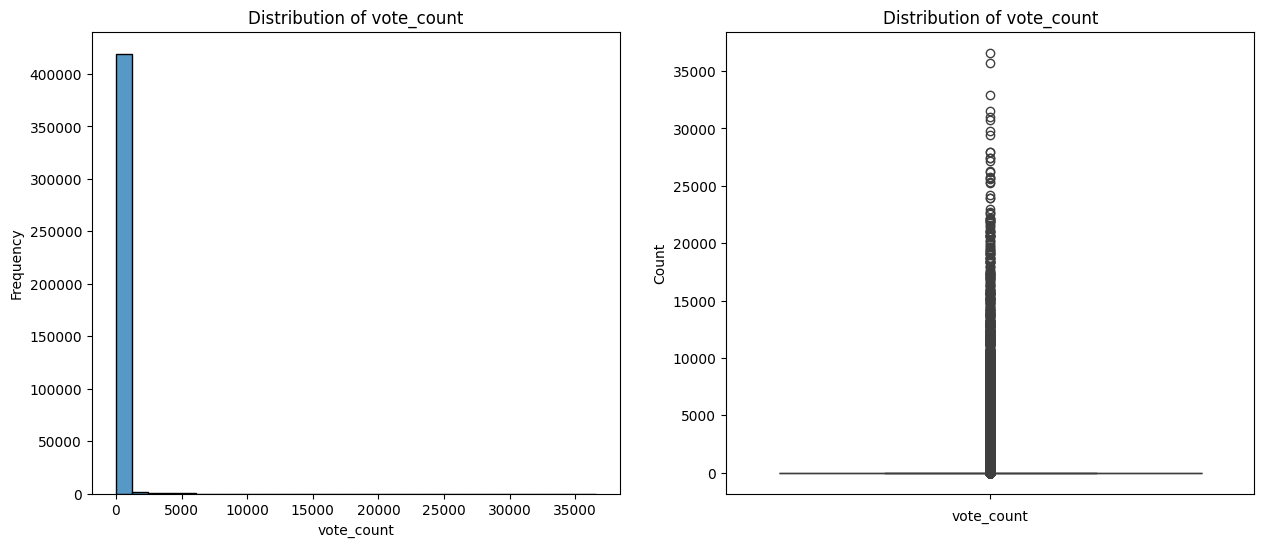

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

This is a highly skewed graph. It is not the result of any weird outliers, but the result of having too many movies with a every small number of vote_count and vote_average of zero.\
Let's see their distributions putting together.

Text(0.5, 1.0, 'Scatterplot of vote_average vs vote_count')

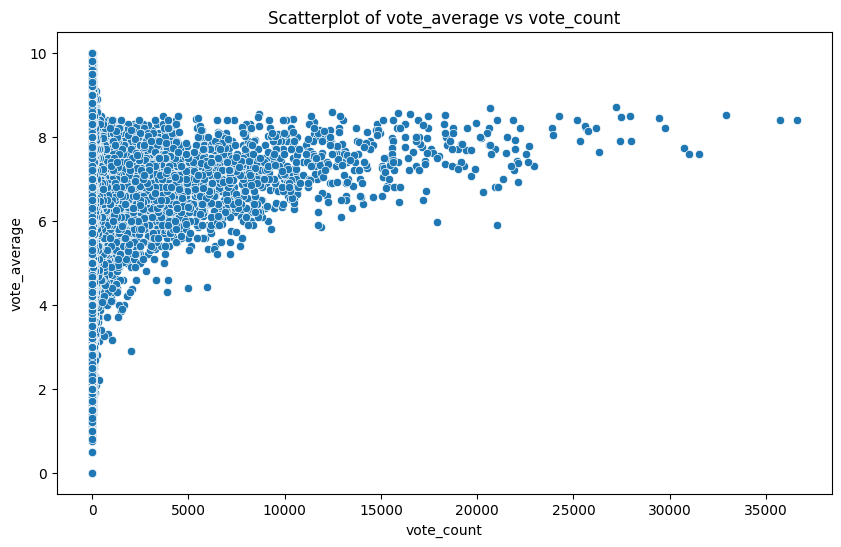

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='vote_average', data=df)
plt.title('Scatterplot of vote_average vs vote_count')

Now we will try to check the distribution without movies with zero votes.

In [17]:
vote_df = df[['vote_average', 'vote_count']]
rows_before = vote_df.shape[0]
vote_df = vote_df[vote_df['vote_count'] > 0]
rows_after = vote_df.shape[0]
print(f'Number of movies with zero votes: {rows_before - rows_after}')

Number of movies with zero votes: 136364


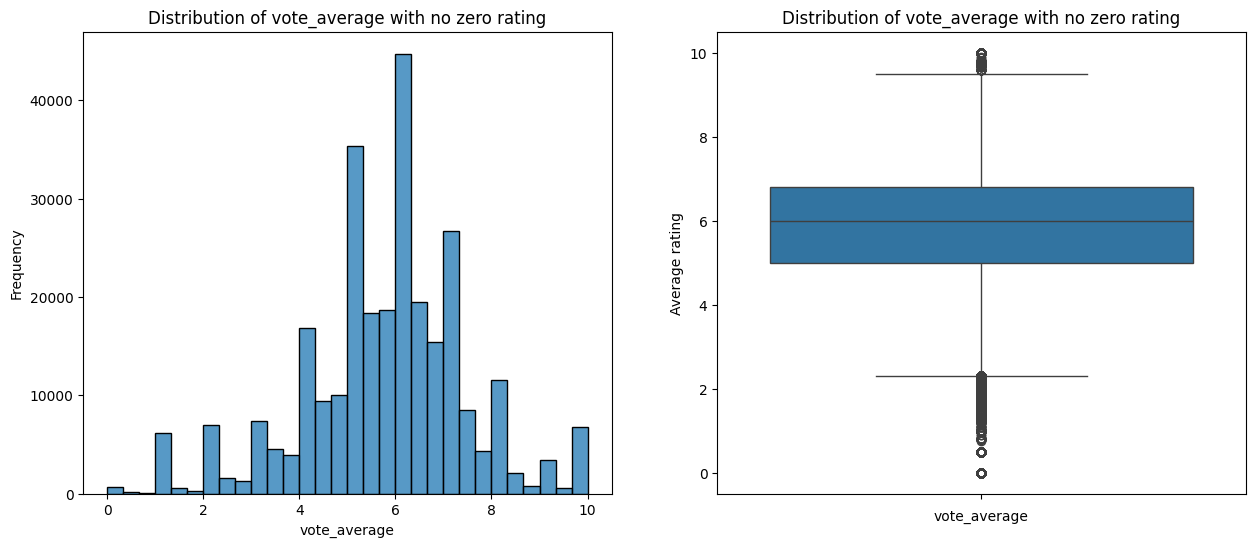

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average with no zero rating')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average with no zero rating')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

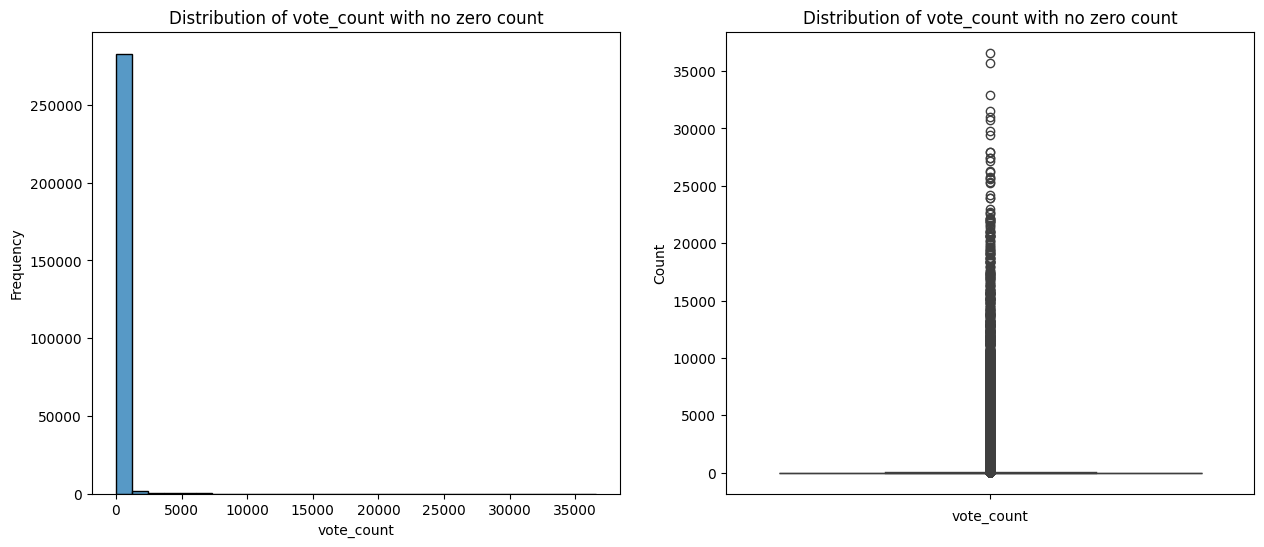

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count with no zero count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count with no zero count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

The distribution of vote_count is still highly skewed since there is a lot of movies with only a small number of votes.

### Status

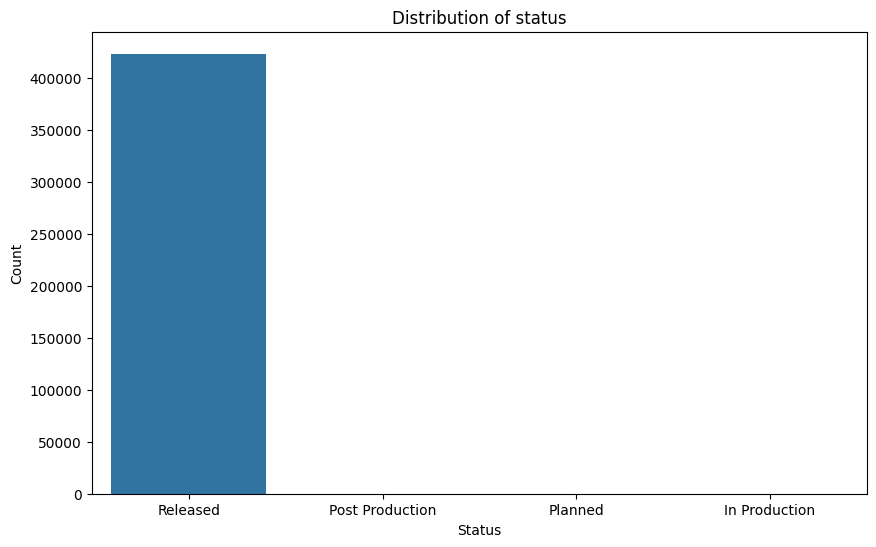

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['status'])
plt.title('Distribution of status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [21]:
df['status'].value_counts()

status
Released           422938
Post Production        32
In Production          22
Planned                 6
Name: count, dtype: int64

### release_date

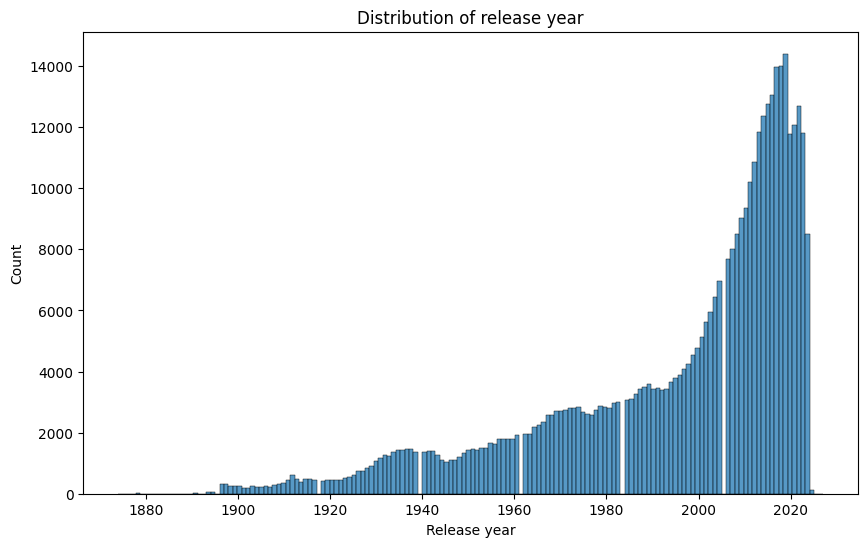

In [22]:
dates = pd.to_datetime(df['release_date'])
plt.figure(figsize=(10, 6))
sns.histplot(dates.dt.year)
plt.title('Distribution of release year')
plt.xlabel('Release year')
plt.ylabel('Count')
plt.show()

### revenue




In [23]:
df['revenue'].value_counts(ascending=False)

revenue
0.0          403851
100000.0         91
1000000.0        80
2000000.0        77
10000.0          67
              ...  
33187.0           1
57696.0           1
858591.0          1
2141028.0         1
2176304.0         1
Name: count, Length: 15365, dtype: int64

Since most of the movies does not have any revenue, it will be another skewed distribution. We will get rid of all the zeros and display the distribution of rest of the data.

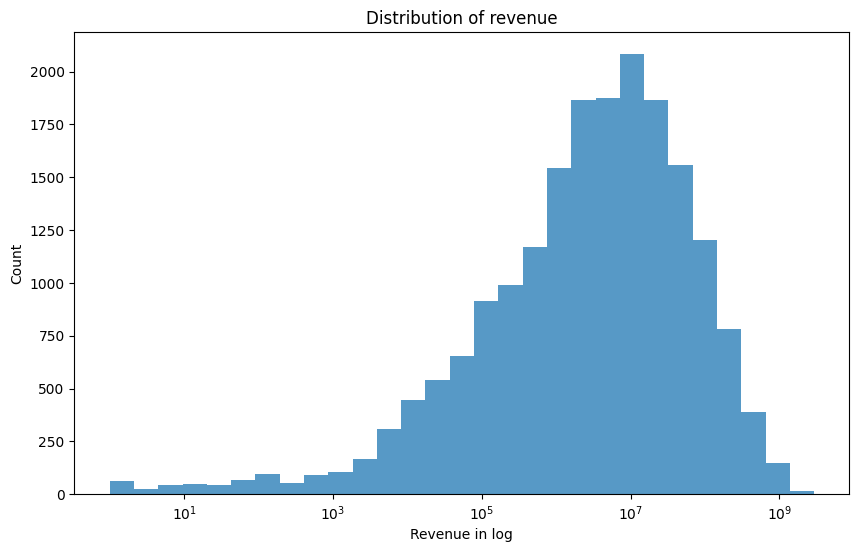

In [24]:
r = df[df['revenue']>0]['revenue']
min_val = r.min()
max_val = r.max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 30)

plt.figure(figsize=(10, 6))
sns.histplot(r, bins=bins)
plt.title('Distribution of revenue')
plt.xlabel('Revenue in log')
plt.ylabel('Count')
plt.xscale('log')
plt.show()

## Encoding

### Encoding Categorical Features

In [25]:
# Handle orginal_title
df['original_title_match'] = df['original_title'] == df['title']
df.drop(columns=['original_title'], inplace=True)

In [26]:
categorical_vars = df.select_dtypes(include=['object', 'category', 'bool']).columns
print("Categorical variables in the DataFrame:")
print(categorical_vars)

Categorical variables in the DataFrame:
Index(['title', 'status', 'release_date', 'original_language', 'tagline',
       'genres', 'production_companies', 'production_countries',
       'spoken_languages', 'cast', 'director', 'director_of_photography',
       'writers', 'producers', 'music_composer', 'original_title_match'],
      dtype='object')


In [27]:
finite_categories = ['status', 'original_language', 'genres', 'production_companies', 
                     'production_countries', 'spoken_languages', 'original_title_match']
for col in finite_categories:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())


Column: status
Unique values: ['Released' 'Post Production' 'Planned' 'In Production']

Column: original_language
Unique values: ['fi' 'en' 'de' 'he' 'es' 'zh' 'ja' 'da' 'fr' 'ko' 'pl' 'sv' 'it' 'bs'
 'hi' 'ru' 'no' 'pt' 'nl' 'el' 'cs' 'bn' 'cn' 'tn' 'sr' 'mn' 'et' 'is'
 'ca' 'ro' 'hu' 'se' 'ps' 'th' 'xx' 'tr' 'sh' 'fa' 'ht' 'bg' 'zu' 'ar'
 'mr' 'ku' 'bo' 'ta' 'tl' 'kk' 'hr' 'id' 'am' 'lt' 'iu' 'pa' 'te' 'sl'
 'vi' 'ml' 'mk' 'sk' 'af' 'ur' 'km' 'nb' 'ms' 'hy' 'uk' 'ka' 'la' 'kn'
 'dz' 'ga' 'eu' 'bm' 'sq' 'gl' 'mo' 'si' 'rw' 'ky' 'eo' 'xh' 'az' 'jv'
 'tg' 'ff' 'lv' 'oc' 'wo' 'ik' 'uz' 'lo' 'ks' 'sm' 'gd' 'cy' 'ln' 'sn'
 'yi' 'tk' 'ab' 'mt' 'sw' 'kl' 'ne' 'fo' 'so' 've' 'lb' 'sa' 'co' 'yo'
 'fy' 'gu' 'sc' 'ig' 'ay' 'mg' 'gn' 'qu' 'cr' 'cv' 'mh' 'mi' 'my' 'to'
 'dv' 'tw' 'or' 'st' 'li' 'as' 'ha' 'ug' 'ak' 'nn' 'be' 'ti' 'ny' 'ty'
 'ss' 'om' 'tt' 'ce' 'rm' 'os' 'nv' 'gv' 'sd' 'lg' 'ba' 'su' 'kg' 'kw'
 'nd' 'sg']

Column: genres
Unique values: ['Comedy, Drama, Romance, Crime' 'Comedy, Dram

In [28]:
# One-hot encode 
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
status_encoded = one_hot_encoder.fit_transform(df[['status', 'original_title_match']])

status_encoded_df = pd.DataFrame(status_encoded, 
                                 columns=one_hot_encoder.get_feature_names_out(['status', 'original_title_match']), 
                                 index=df.index)
df = pd.concat([df, status_encoded_df], axis=1)
df.drop(columns=['status', 'original_title_match'], inplace=True)

# Target encode 
target_encode_cols = ['original_language', 'production_companies', 'production_countries', 'spoken_languages', 'genres']
target_col = 'imdb_rating'
df[target_encode_cols] = df[target_encode_cols].fillna('Missing')

for col in target_encode_cols:
    target_mean = df.groupby(col)[target_col].mean()
    df[f"{col}_target_encoded"] = df[col].map(target_mean)

df.drop(columns=target_encode_cols, inplace=True)

print(df.head())

                              title  vote_average  vote_count release_date  \
0                             Ariel           7.1       335.0   1988-10-21   
1               Shadows in Paradise           7.3       369.0   1986-10-17   
2                        Four Rooms           5.8      2628.0   1995-12-09   
3                    Judgment Night           6.5       331.0   1993-10-15   
4  Life in Loops (A Megacities RMX)           7.5        27.0   2006-01-01   

      revenue  runtime      budget  popularity  \
0         0.0     73.0         0.0      11.915   
1         0.0     74.0         0.0      16.287   
2   4257354.0     98.0   4000000.0      21.312   
3  12136938.0    109.0  21000000.0       8.924   
4         0.0     80.0     42000.0       3.203   

                                             tagline  \
0                                                NaN   
1                                                NaN   
2  Twelve outrageous guests. Four scandalous requ...   
3     

### Dimension Reduction:

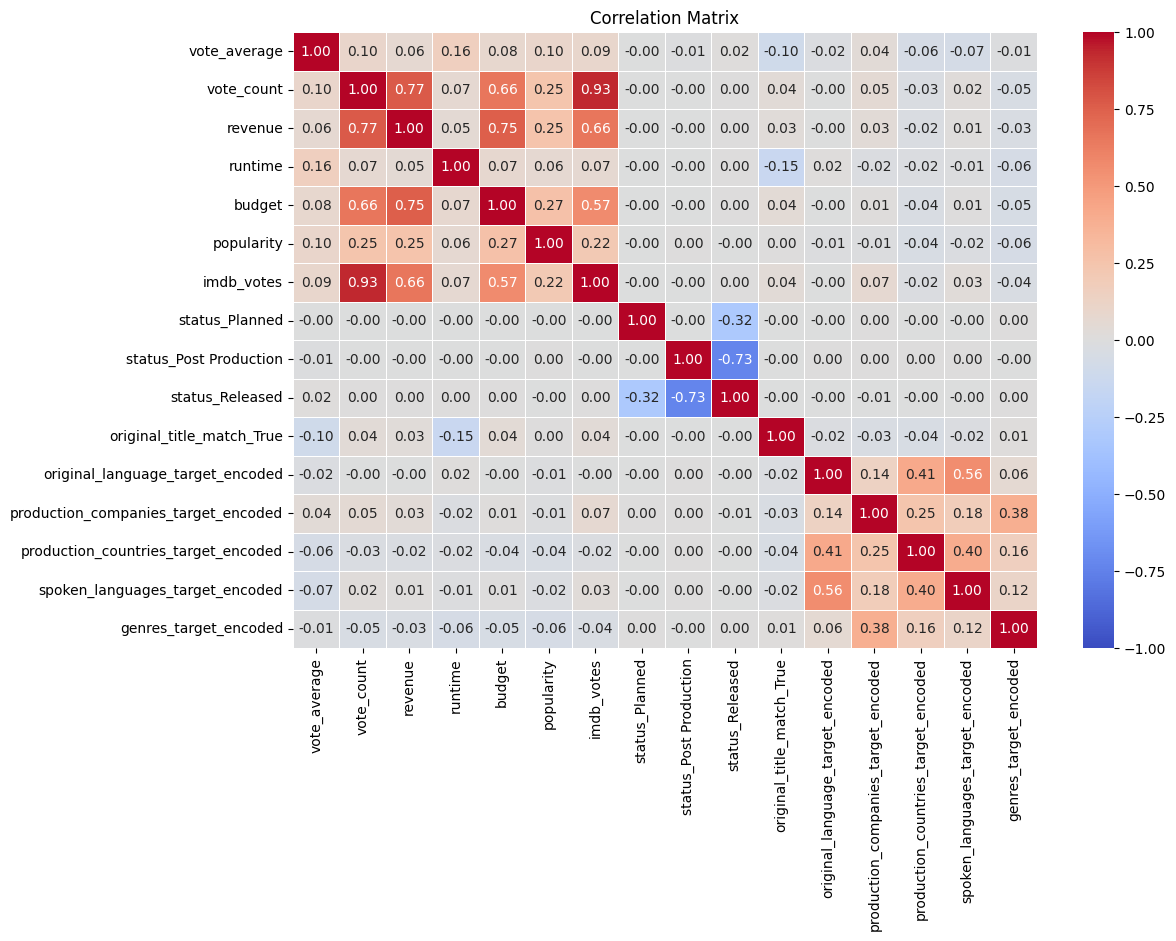

Dropped columns: {'imdb_votes'}
                              title  vote_average  vote_count release_date  \
0                             Ariel           7.1       335.0   1988-10-21   
1               Shadows in Paradise           7.3       369.0   1986-10-17   
2                        Four Rooms           5.8      2628.0   1995-12-09   
3                    Judgment Night           6.5       331.0   1993-10-15   
4  Life in Loops (A Megacities RMX)           7.5        27.0   2006-01-01   

      revenue  runtime      budget  popularity  \
0         0.0     73.0         0.0      11.915   
1         0.0     74.0         0.0      16.287   
2   4257354.0     98.0   4000000.0      21.312   
3  12136938.0    109.0  21000000.0       8.924   
4         0.0     80.0     42000.0       3.203   

                                             tagline  \
0                                                NaN   
1                                                NaN   
2  Twelve outrageous guests. F

In [29]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(['imdb_rating'])
df_numerical = df[numerical_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


cols_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            cols_to_drop.add(colname)

df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")
print(df.head())


### Handling release_date

In [30]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['decade'] = (df['release_date'].dt.year // 10) * 10
decades = df['decade'].values.reshape(-1, 1)

encoder = OrdinalEncoder()
df['release_date_decade_encoded'] = encoder.fit_transform(decades)
df.drop(columns=['release_date', 'decade'], inplace=True)

### Text Vectorization

In [31]:
vectorize_cols = ['title', 'tagline', 'cast', 'director',
                  'director_of_photography', 'writers',
                  'producers', 'music_composer']

# vectorize_cols = ['title']

vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

for col in tqdm(vectorize_cols):
    df[col] = df[col].fillna('')
    df[col] = df[col].apply(lambda x: ' '.join([name.strip().replace(' ', '_') for name in x.split(',')]))


    tfidf_matrix = vectorizer.fit_transform(df[col])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat([df, tfidf_df], axis=1)

print(df.head())

100%|██████████| 8/8 [00:16<00:00,  2.04s/it]

                              title  vote_average  vote_count     revenue  \
0                             Ariel           7.1       335.0         0.0   
1               Shadows_in_Paradise           7.3       369.0         0.0   
2                        Four_Rooms           5.8      2628.0   4257354.0   
3                    Judgment_Night           6.5       331.0  12136938.0   
4  Life_in_Loops_(A_Megacities_RMX)           7.5        27.0         0.0   

   runtime      budget  popularity  \
0     73.0         0.0      11.915   
1     74.0         0.0      16.287   
2     98.0   4000000.0      21.312   
3    109.0  21000000.0       8.924   
4     80.0     42000.0       3.203   

                                             tagline  \
0                                                      
1                                                      
2  Twelve_outrageous_guests._Four_scandalous_requ...   
3     Don't_move._Don't_whisper._Don't_even_breathe.   
4                           

In [32]:
df = df.drop(columns=vectorize_cols)
print(df.shape)

(422998, 817)


## Sampling & Normalization

In [33]:
normalize_col = ['vote_average', 'vote_count', 'revenue', 'budget', 'popularity', 'runtime',
                 'release_date_decade_encoded', 'original_language_target_encoded', 'production_companies_target_encoded',
                 'production_countries_target_encoded', 'spoken_languages_target_encoded', 'genres_target_encoded']

### Random split

In [34]:
X_train, X_test, y_train, y_test= train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.1, random_state=42)
scaler = StandardScaler()
X_train[normalize_col] = scaler.fit_transform(X_train[normalize_col])
X_test[normalize_col] = scaler.transform(X_test[normalize_col])
print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (380698, 816)
Shape of the test set: (42300, 816)


### Stratified split

In [35]:
kbd = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='quantile')
y_bin = kbd.fit_transform(df[['imdb_rating']])
X_train_str, X_temp_str, y_train_str, y_temp_str = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42, stratify=y_bin)
y_temp_str = pd.DataFrame(y_temp_str, columns=['imdb_rating'])
y_test_bin = kbd.transform(y_temp_str)
X_val_str, X_test_str, y_val_str, y_test_str = train_test_split(X_temp_str, y_temp_str, test_size=0.5, random_state=42, stratify=y_test_bin)
scaler_str = StandardScaler()
X_train_str[normalize_col] = scaler_str.fit_transform(X_train_str[normalize_col])
X_val_str[normalize_col] = scaler_str.transform(X_val_str[normalize_col])
X_test_str[normalize_col] = scaler_str.transform(X_test_str[normalize_col])
print(f'Shape of the training set: {X_train_str.shape}')
print(f'Shape of the validation set: {X_val_str.shape}')
print(f'Shape of the test set: {X_test_str.shape}')

Shape of the training set: (338398, 816)
Shape of the validation set: (42300, 816)
Shape of the test set: (42300, 816)


## Model

### KNN

In [36]:
param_grid_str = {'n_neighbors': [5, 10, 20, 50, 100],
                    'leaf_sizes': [30, 50, 100]}
best_val_score_str = 0
best_params_str = None
for n_neighbors in param_grid_str['n_neighbors']:
    for leaf_size in param_grid_str['leaf_sizes']:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, leaf_size=leaf_size)
        knn.fit(X_train_str, y_train_str)
        val_score = knn.score(X_val_str, y_val_str)
        if val_score > best_val_score_str:
            best_val_score_str = val_score
            best_params_str = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
print(f'Best stratified validation score: {best_val_score_str}')
print(f'Best stratified parameters: {best_params_str}')

Best stratified validation score: 0.5770871755632492
Best stratified parameters: {'n_neighbors': 20, 'leaf_size': 30}


In [37]:
best_knn_str = KNeighborsRegressor(n_neighbors=best_params_str['n_neighbors'], leaf_size=best_params_str['leaf_size'])
best_knn_str.fit(X_train_str, y_train_str)
test_score_str = best_knn_str.score(X_test_str, y_test_str)
print(f'Test score for best stratified model: {test_score_str}')

Test score for best stratified model: 0.5823417227021552


### Lasso Regression

In [38]:
param_grid_lasso_str = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
                        'max_iter': [1000, 5000, 10000]}
best_val_score_lasso_str = 0
best_params_lasso_str = None
for alpha in param_grid_lasso_str['alpha']:
    for max_iter in param_grid_lasso_str['max_iter']:
        lasso = Lasso(alpha=alpha, max_iter=max_iter)
        lasso.fit(X_train_str, y_train_str)
        val_score = lasso.score(X_val_str, y_val_str)
        if val_score > best_val_score_lasso_str:
            best_val_score_lasso_str = val_score
            best_params_lasso_str = {'alpha': alpha, 'max_iter': max_iter}
print(f'Best stratified validation score: {best_val_score_lasso_str}')
print(f'Best stratified parameters: {best_params_lasso_str}')

Best stratified validation score: 0.48595007574887283
Best stratified parameters: {'alpha': 0.01, 'max_iter': 1000}


In [39]:
best_lasso = Lasso(alpha=best_params_lasso_str['alpha'], max_iter=best_params_lasso_str['max_iter'])
best_lasso.fit(X_train_str, y_train_str)
test_score_lasso = best_lasso.score(X_test_str, y_test_str)
print(f'Test score for best stratified model: {test_score_lasso}')

Test score for best stratified model: 0.4933214247243197


### Ridge Regression

In [40]:
param_grid_ridge_str = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
                        'max_iter': [1000, 5000, 10000],
                        'solver': ['auto']}
best_val_score_ridge_str = 0
best_params_ridge_str = None
for alpha in param_grid_ridge_str['alpha']:
    for max_iter in param_grid_ridge_str['max_iter']:
        for solver in param_grid_ridge_str['solver']:
            ridge = Ridge(alpha=alpha, max_iter=max_iter, solver=solver)
            ridge.fit(X_train_str, y_train_str)
            val_score = ridge.score(X_val_str, y_val_str)
            if val_score > best_val_score_ridge_str:
                best_val_score_ridge_str = val_score
                best_params_ridge_str = {'alpha': alpha, 'max_iter': max_iter, 'solver': solver}
print(f'Best stratified validation score: {best_val_score_ridge_str}')
print(f'Best stratified parameters: {best_params_ridge_str}')

Best stratified validation score: 0.49094816945186515
Best stratified parameters: {'alpha': 10, 'max_iter': 1000, 'solver': 'auto'}


In [41]:
best_ridge = Ridge(alpha=best_params_ridge_str['alpha'], 
                   max_iter=best_params_ridge_str['max_iter'], 
                   solver=best_params_ridge_str['solver'])
best_ridge.fit(X_train_str, y_train_str)
test_score_ridge = best_ridge.score(X_test_str, y_test_str)
print(f'Test score for best stratified model: {test_score_ridge}')

Test score for best stratified model: 0.4980094501573543


### XGBoost

In [36]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

best_xgb_val_score = float('-inf')
best_xgb_params = None

for max_depth in xgb_param_grid['max_depth']:
    for learning_rate in xgb_param_grid['learning_rate']:
        for n_estimators in xgb_param_grid['n_estimators']:
            xgboost_model = xgb.XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
            xgboost_model.fit(X_train_str.to_numpy(), y_train_str.to_numpy())
            val_score = xgboost_model.score(X_val_str.to_numpy(), y_val_str.to_numpy())

            if val_score > best_xgb_val_score:
                best_xgb_val_score = val_score
                best_xgb_params = {
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators
                }

print(f'Best XGBoost validation score: {best_xgb_val_score}')
print(f'Best XGBoost parameters: {best_xgb_params}')

Best XGBoost validation score: 0.6187335387634375
Best XGBoost parameters: {'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 200}


In [37]:
best_xgboost_model = xgb.XGBRegressor(**best_xgb_params)
best_xgboost_model.fit(X_train_str.to_numpy(), y_train_str.to_numpy())
xgb_test_score = best_xgboost_model.score(X_test_str.to_numpy(), y_test_str.to_numpy())
print(f'Test score for best XGBoost model: {xgb_test_score}')

Test score for best XGBoost model: 0.6220820831265997


### Random Forest Regression

In [44]:
param_grid_rf_str = {
    'n_estimators': [5, 10, 20],
    'max_depth': [10, 30, 60, 100],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
}
best_val_score_rf_str = 0
best_params_rf_str = None

for n_estimators in param_grid_rf_str['n_estimators']:
    for max_depth in param_grid_rf_str['max_depth']:
        for max_features in param_grid_rf_str['max_features']:
            for min_samples_split in param_grid_rf_str['min_samples_split']:
                rf = RandomForestRegressor(n_estimators=n_estimators, 
                                           max_depth=max_depth, 
                                           max_features=max_features, 
                                           min_samples_split=min_samples_split)
                rf.fit(X_train_str, y_train_str)
                val_score = rf.score(X_val_str, y_val_str)
                if val_score > best_val_score_rf_str:
                    best_val_score_rf_str = val_score
                    best_params_rf_str = {'n_estimators': n_estimators, 
                                          'max_depth': max_depth, 
                                          'max_features': max_features, 
                                          'min_samples_split': min_samples_split}
print(f'Best stratified validation score: {best_val_score_rf_str}')
print(f'Best stratified parameters: {best_params_rf_str}')

Best stratified validation score: 0.5926983261248244
Best stratified parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10}


In [45]:
# Try different number of estimators based on the best parameters
param_grid_rf_str_n_estimators = {'n_estimators': [10, 20, 50, 100, 200]}
best_val_score_rf_str = 0
best_params_rf_str = None
for n_estimators in param_grid_rf_str_n_estimators['n_estimators']:
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=100,
                               max_features='sqrt',
                               min_samples_split=2)
    rf.fit(X_train_str, y_train_str)
    val_score = rf.score(X_val_str, y_val_str)
    if val_score > best_val_score_rf_str:
        best_val_score_rf_str = val_score
        best_params_rf_str = {'n_estimators': n_estimators}

In [50]:
print(f'Best stratified validation score: {best_val_score_rf_str}')
print(f'Best stratified parameters: {best_params_rf_str}')

Best stratified validation score: 0.5987891076701819
Best stratified parameters: {'n_estimators': 200}


In [46]:
best_rf_str = RandomForestRegressor(n_estimators=best_params_rf_str['n_estimators'],
                                    max_depth=100,
                                    max_features='sqrt',
                                    min_samples_split=2)
best_rf_str.fit(X_train_str, y_train_str)
test_score_rf_str = best_rf_str.score(X_test_str, y_test_str)
print(f'Test score for best stratified model: {test_score_rf_str}')

Test score for best stratified model: 0.6079295740640448


### SVR

SVR is not scalable method. The training is taking too long for our dataset

In [47]:
# param_grid_svr_str = {
#     'C': [0.1, 1, 10],
#     'epsilon': [0.1, 0.5, 1],
#     'kernel': ['linear', 'rbf']
# }
# best_val_score = float('-inf')
# best_params = None

# for C in param_grid_svr_str['C']:
#   for epsilon in param_grid_svr_str['epsilon']:
#     for kernel in param_grid_svr_str['kernel']:
#       svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
#       svr.fit(X_train_str, y_train_str)
#       val_score = svr.score(X_val_str, y_val_str)

#       if val_score > best_val_score:
#         best_val_score = val_score
#         best_params = {'C': C, 'epsilon': epsilon, 'kernel': kernel}
# print(f'Best validation score: {best_val_score}')
# print(f'Best parameters: {best_params}')

In [48]:
# best_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_params['kernel'])
# best_svr.fit(X_train_str, y_train_str)
# test_score = best_svr.score(X_test_str, y_test_str)
# print(f'Test score for best model: {test_score}')

### MLP

In [49]:
# 1. Setup and Model Definition
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np
import random
import os

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Layer 1: Input -> 256 neurons
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        # Layer 2: 256 neurons -> 128 neurons
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        # Layer 3: 128 neurons -> 64 neurons
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        # Output Layer: 64 neurons -> 1 neuron
        self.output = nn.Linear(64, 1)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

# 2. Data Preparation
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler

def to_dense(X):
    if issparse(X):
        return X.toarray()
    else:
        return X

# Convert DataFrame to numpy arrays
X_train_dense = to_dense(X_train_str.values)
X_val_dense = to_dense(X_val_str.values)
X_test_dense = to_dense(X_test_str.values)

# Apply standardization to the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_val_scaled = scaler.transform(X_val_dense)
X_test_scaled = scaler.transform(X_test_dense)

# Apply logarithmic transformation to the target variable
y_train_log = np.log1p(y_train_str.values.reshape(-1, 1))
y_val_log = np.log1p(y_val_str.values.reshape(-1, 1))
y_test_log = np.log1p(y_test_str.values.reshape(-1, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_log)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_log)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_log)

# Data integrity checks
assert not torch.isnan(X_train_tensor).any(), "NaN values in X_train_tensor"
assert not torch.isnan(y_train_tensor).any(), "NaN values in y_train_tensor"
assert not torch.isnan(X_val_tensor).any(), "NaN values in X_val_tensor"
assert not torch.isnan(y_val_tensor).any(), "NaN values in y_val_tensor"
assert not torch.isnan(X_test_tensor).any(), "NaN values in X_test_tensor"
assert not torch.isnan(y_test_tensor).any(), "NaN values in y_test_tensor"

assert not torch.isinf(X_train_tensor).any(), "Infinite values in X_train_tensor"
assert not torch.isinf(y_train_tensor).any(), "Infinite values in y_train_tensor"
assert not torch.isinf(X_val_tensor).any(), "Infinite values in X_val_tensor"
assert not torch.isinf(y_val_tensor).any(), "Infinite values in y_val_tensor"
assert not torch.isinf(X_test_tensor).any(), "Infinite values in X_test_tensor"
assert not torch.isinf(y_test_tensor).any(), "Infinite values in y_test_tensor"

# Ensure consistent feature order across datasets
assert list(X_train_str.columns) == list(X_val_str.columns), "Feature mismatch between training and validation sets"
assert list(X_train_str.columns) == list(X_test_str.columns), "Feature mismatch between training and test sets"

# Create data loaders with higher batch size
batch_size = 256  # Increased batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import time  # To measure epoch durations

# 3. Training

# Number of epochs to train the model
num_epochs = 100

# Maximum gradient norm for gradient clipping to prevent exploding gradients
max_grad_norm = 1.0

# Initialize the model and move it to the appropriate device (CPU or GPU)
model = MLP(input_size=X_train_tensor.shape[1]).to(device)

# Define the optimizer with adjusted learning rate and weight decay
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,         # Decreased learning rate
    weight_decay=1e-6  # Adjusted weight decay
)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the learning rate scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',         # Maximize the validation R² score
    factor=0.5,         # Reduce LR by a factor of 0.5
    patience=10,        # Number of epochs with no improvement after which LR will be reduced
    verbose=True
)

# Print header for training progress
print("\nStarting Training...")
print(f"{'Epoch':^6} | {'Train Loss':^12} | {'Val Loss':^12} | {'Train R²':^10} | {'Val R²':^10} | {'Time(s)':^8}")
print("-" * 74)

# Lists to store metrics for plotting or analysis
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# Loop over epochs
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time of the epoch

    # --------------------
    # Training Phase
    # --------------------
    model.train()             # Set model to training mode
    train_loss = 0            # Cumulative loss for the epoch
    train_outputs_all = []    # List to store all outputs for R² calculation
    train_targets_all = []    # List to store all targets for R² calculation

    # Iterate over batches in the training loader
    for X_batch, y_batch in train_loader:
        # Move data to the appropriate device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()     # Zero the parameter gradients

        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss

        loss.backward()           # Backward pass (compute gradients)

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()          # Update model parameters

        # Accumulate total loss (loss.item() gives average loss per sample in the batch)
        train_loss += loss.item() * X_batch.size(0)

        # Store outputs and targets for R² calculation
        train_outputs_all.append(outputs.detach().cpu().numpy())
        train_targets_all.append(y_batch.cpu().numpy())

    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Flatten outputs and targets and calculate R² score
    train_outputs = np.concatenate(train_outputs_all).flatten()
    train_targets = np.concatenate(train_targets_all).flatten()
    train_r2 = r2_score(train_targets, train_outputs)
    train_r2_scores.append(train_r2)

    # --------------------
    # Validation Phase
    # --------------------
    model.eval()              # Set model to evaluation mode
    val_loss = 0              # Cumulative validation loss
    val_outputs_all = []      # List to store all outputs for R² calculation
    val_targets_all = []      # List to store all targets for R² calculation

    with torch.no_grad():     # Disable gradient computation
        for X_batch, y_batch in val_loader:
            # Move data to the appropriate device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)             # Forward pass
            loss = criterion(outputs, y_batch)   # Compute loss

            val_loss += loss.item() * X_batch.size(0)  # Accumulate total loss

            # Store outputs and targets
            val_outputs_all.append(outputs.cpu().numpy())
            val_targets_all.append(y_batch.cpu().numpy())

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    # Flatten outputs and targets and calculate R² score
    val_outputs = np.concatenate(val_outputs_all).flatten()
    val_targets = np.concatenate(val_targets_all).flatten()
    val_r2 = r2_score(val_targets, val_outputs)
    val_r2_scores.append(val_r2)

    # Step the scheduler based on validation R²
    scheduler.step(val_r2)

    # Calculate epoch duration
    epoch_time = time.time() - start_time

    # --------------------
    # Print Epoch Summary
    # --------------------
    print(f"{epoch+1:6d} | {avg_train_loss:12.6f} | {avg_val_loss:12.6f} | "
          f"{train_r2:10.4f} | {val_r2:10.4f} | {epoch_time:8.2f}s")

# --------------------
# Post-Training
# --------------------

# Print final training summary
print("\nTraining complete.")

# 4. Save and Load Model
def save_model(model, save_path='models/best_mlp_pytorch.pt'):
    os.makedirs('models', exist_ok=True)
    model_info = {
        'state_dict': model.state_dict(),
        'input_size': model.layer1[0].in_features,  # Input size of the first Linear layer
        'architecture': 'MLP'
    }
    torch.save(model_info, save_path)
    print(f"Model saved to {save_path}")

def load_model(load_path='models/best_mlp_pytorch.pt'):
    model_info = torch.load(load_path)
    model = MLP(
        input_size=model_info['input_size']
    ).to(device)
    model.load_state_dict(model_info['state_dict'])
    return model

# Save the model
save_model(model)



# 5. Testing and Prediction
def evaluate_model(model, test_loader):
    model.eval()
    test_predictions = []
    test_targets = []
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            test_predictions.append(outputs.cpu().numpy())
            test_targets.append(y_batch.cpu().numpy())

    # Concatenate and flatten arrays
    test_predictions = np.concatenate(test_predictions).flatten()
    test_targets = np.concatenate(test_targets).flatten()

    # Inverse transform predictions and targets
    test_predictions_exp = np.expm1(test_predictions)
    test_targets_exp = np.expm1(test_targets)

    # Calculate metrics in the original scale
    mse = np.mean((test_predictions_exp - test_targets_exp) ** 2)
    r2 = r2_score(test_targets_exp, test_predictions_exp)
    avg_test_loss = test_loss / len(test_dataset)

    return avg_test_loss, mse, r2

def predict(model, new_data):
    model.eval()
    with torch.no_grad():
        X = torch.FloatTensor(new_data).to(device)
        outputs = model(X)
        predictions_log = outputs.cpu().numpy()
        predictions = np.expm1(predictions_log)  # Inverse transform to original scale
        return predictions

# Test the model
test_loss, mse, r2 = evaluate_model(model, test_loader)
print("\nTest Set Performance:")
print(f'Average Test Loss (log scale): {test_loss:.6f}')
print(f'Mean Squared Error (original scale): {mse:.6f}')
print(f'R² Score (original scale): {r2:.6f}')


Using device: cuda


/home/jiayi/env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting Training...
Epoch  |  Train Loss  |   Val Loss   |  Train R²  |   Val R²   | Time(s) 
--------------------------------------------------------------------------
     1 |     0.319417 |     0.029219 |    -6.9962 |     0.2618 |     5.17s
     2 |     0.073473 |     0.024503 |    -0.8393 |     0.3809 |     5.30s
     3 |     0.058721 |     0.022186 |    -0.4700 |     0.4395 |     5.34s
     4 |     0.049895 |     0.021238 |    -0.2491 |     0.4634 |     5.33s
     5 |     0.044660 |     0.020327 |    -0.1180 |     0.4864 |     5.16s
     6 |     0.040482 |     0.019825 |    -0.0134 |     0.4991 |     5.29s
     7 |     0.037277 |     0.019566 |     0.0668 |     0.5057 |     5.28s
     8 |     0.035235 |     0.019715 |     0.1179 |     0.5019 |     5.27s
     9 |     0.033316 |     0.018867 |     0.1660 |     0.5233 |     5.14s
    10 |     0.032059 |     0.018914 |     0.1974 |     0.5221 |     5.27s
    11 |     0.030799 |     0.019188 |     0.2290 |     0.5152 |     5.28s
    

## Feature importance with the best model (XGBoost)

### XGBoost built-in feature importance

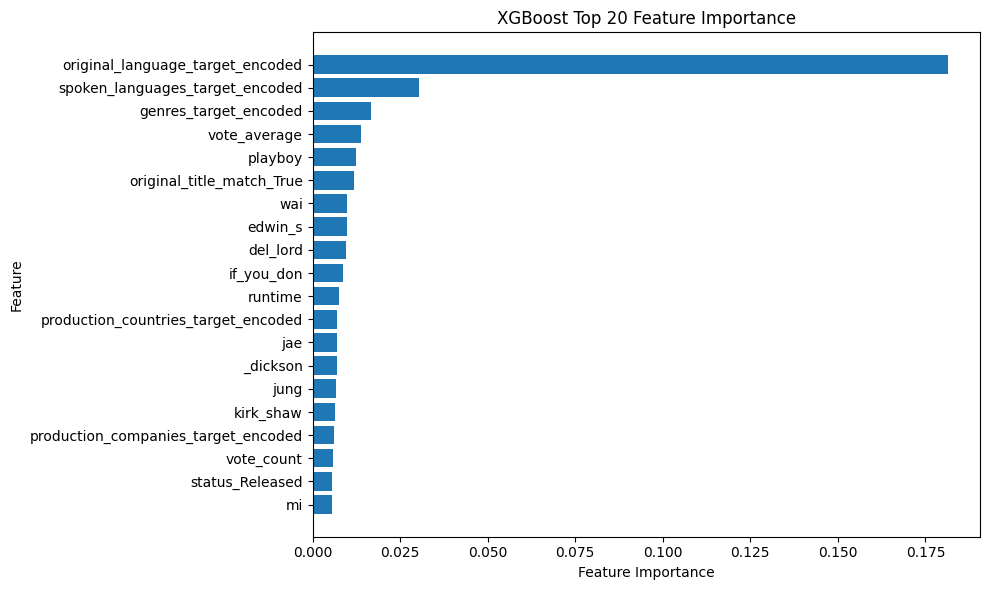

In [38]:
sorted_index = best_xgboost_model.feature_importances_.argsort()
top_20_idx = sorted_index[-20:]
plt.figure(figsize=(10, 6))
plt.barh(df.columns[top_20_idx], best_xgboost_model.feature_importances_[top_20_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Top 20 Feature Importance')
plt.tight_layout()
plt.show()

### Shap feature importance

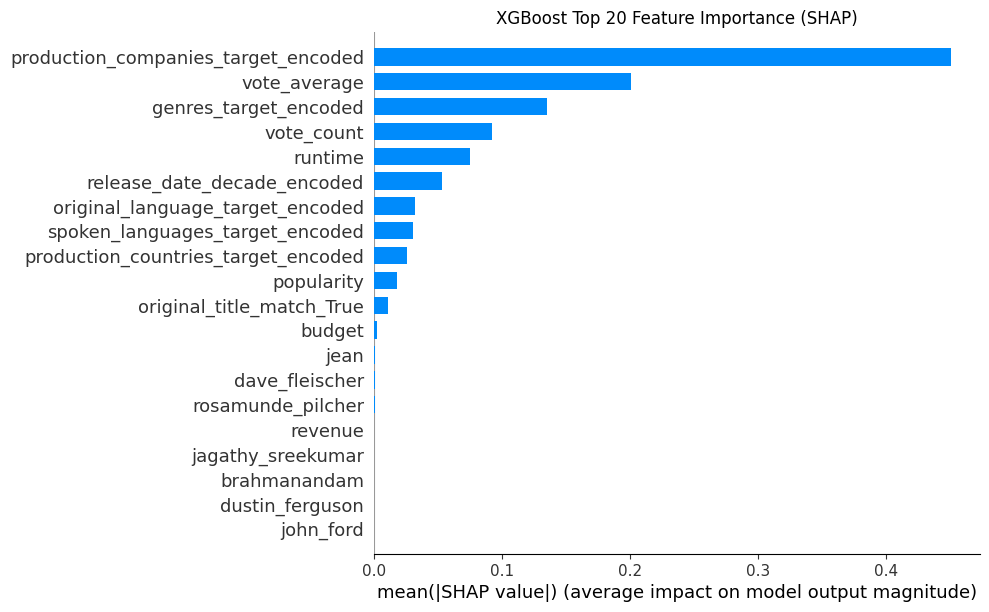

In [43]:
explainer = shap.TreeExplainer(best_xgboost_model)
shap_values = explainer.shap_values(X_test.to_numpy())

shap.summary_plot(shap_values, 
                 X_test, 
                 plot_type="bar", 
                 max_display=20,  
                 show=False)      

plt.gcf().set_size_inches(10, 6) 
plt.tight_layout()
plt.title('XGBoost Top 20 Feature Importance (SHAP)')
plt.show()